In [5]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification
## Sections 3 and 4:  Document Similarity, and Word Embedding Regularization

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)

We consider four term weighting schemes:

- Bag of Words (BOW)
- TF-IDF

And we consider two similarities:

- Inner Product (IP)
- Word Mover's Distance (WMD)

Not all combinations of document representations, term weighting schemes, and similarities are supported by `dataset.py`:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | Soft VSM IP |
|--|--|--|--|
| BOW | ✅ | ✅ | ❌ |
| TF-IDF | ✅ | ❌ | ✅ |

## Section 4: Word Embedding Regularization

In [6]:
%matplotlib inline

from matplotlib import rcParams
import matplotlib.pyplot as plt

# hatches = (' ', 'OO', '\\\\\\\\\\\\\\', 'ooo', '///', '.....', '**')
palette = [
    (253, 253, 227),
    (244, 242, 69),
    (251, 194, 36),
    (246, 131, 90),
    (241, 63, 154),
    (110, 66, 164),
    (32, 35, 87),
]
palette = [(r / 255.0, g / 255.0, b / 255.0) for r, g, b in palette]
rcParams['font.size'] = 9
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']
# rcParams['hatch.linewidth'] = 0.3
rcParams["legend.frameon"] = False
rcParams["figure.figsize"] = (3.45, 2)
# plt.style.use('fivethirtyeight')

### Figure 1: T-SNE visualizations of non-regularized (top left) and orthogonalized (top right) embeddings for the 40 most common words on the first 100 MiB of the English Wikipedia, and matrices of non-regularized (bottom left) and orthogonalized (bottom right) word similarity matrices.

In [7]:
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def dense_word_similarity(model, w1, w2, threshold, exponent):
    similarity = -cosine(model[w1], model[w2]) + 1.0
    if similarity > threshold:
        return similarity**exponent
    else:
        return threshold

def sparse_word_similarity(dictionary, matrix, w1, w2):
    try:
        similarity = matrix[dictionary.token2id[w1], dictionary.token2id[w2]]
        return similarity
    except IndexError:
        return 0.0

def get_words(model, sample_size):
    blacklist = set(('</s>', 's'))
    pinned_words = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

    pinned_word_indices = {word: index for index, word in enumerate(pinned_words)}
    pinned_indices = [-1] * len(pinned_words)
    indices = []
    words = []
    for index, word in enumerate(model.index2word[:sample_size + len(blacklist)]):
        if word not in blacklist:
            if word in pinned_word_indices:
                pinned_indices[pinned_word_indices[word]] = index
            else:
                indices.append(index)
                words.append(word)
    return zip(
        indices[:int(sample_size / 4 - len(pinned_words) / 2)] \
            + pinned_indices
            + indices[int(sample_size / 4 - len(pinned_words) / 2):],
        words[:int(sample_size / 4 - len(pinned_words) / 2)] \
            + pinned_words \
            + words[int(sample_size / 4 - len(pinned_words) / 2):])

def dense_plot_words(model, sample_size, basename):
    labels = []
    tokens = []
    for _, word in get_words(model, sample_size):
        tokens.append(model[word])
        labels.append(word)

    new_values = PCA(n_components=min(50, sample_size), random_state=23).fit_transform(tokens)
    new_values = TSNE(n_components=2, random_state=23, metric='cosine').fit_transform(new_values)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plot_words(x, y, labels, basename)

def sparse_plot_words(model, sample_size, basename, matrix):
    labels = []
    tokens = []
    for _, word in get_words(model, sample_size):
        tokens.append(model[word])
        labels.append(word)

    new_values = TSNE(n_components=2, random_state=23, metric='precomputed').fit_transform(-matrix + 1)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plot_words(x, y, labels, basename)

def plot_words(x, y, labels, basename):
    fig = plt.figure(figsize=(2.9, 2.9))
    ax = fig.add_subplot(111)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(
            labels[i],
            xy=(x[i], y[i]),
            xytext=(0, 3),
            textcoords='offset points',
            ha='right',
            va='bottom',
        )
    plt.tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
        labeltop=False,
        labelbottom=False,
        labelleft=False,
        labelright=False,
    )
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('{}-{}.pdf'.format(basename, 'most_common'))

2019-10-25 22:59:43,867 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


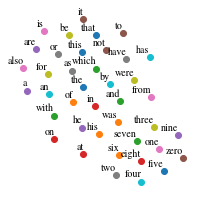

In [5]:
from dataset import common_embeddings

num_bits = 32
model = common_embeddings[num_bits]
sample_size = 40
basename = 'figures/embedding-words'

dense_plot_words(model, sample_size, basename)

2019-10-25 22:59:51,810 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


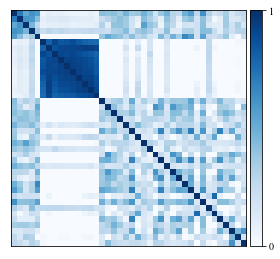

In [6]:
from itertools import product

import numpy as np
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import PowerNorm
from matplotlib.figure import figaspect

threshold = 0.0
exponent = 1
indices, words = zip(*get_words(model, sample_size))

matrix = np.zeros((sample_size, sample_size))
for i, j in product(range(sample_size), range(sample_size)):
    matrix[i, j] = dense_word_similarity(model, words[i], words[j], threshold, exponent)

fig = plt.figure(figsize=figaspect(1.0))
ax = fig.add_subplot(111)
im = ax.matshow(
    matrix,
    norm=PowerNorm(
        gamma=1.0,
        vmin=0.0,
        vmax=1.0,
        clip=True,
    ),
    cmap=plt.cm.Blues,
)
plt.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labeltop=False,
    labelbottom=False,
    labelleft=False,
    labelright=False,
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, ticks=[0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])
plt.tight_layout()
plt.savefig('figures/embedding-dense_termsim.pdf', dpi=300)
plt.show()

2019-10-25 22:59:55,756 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


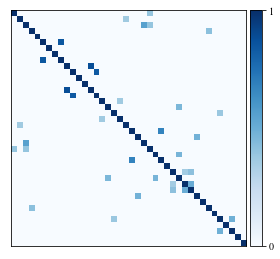

In [7]:
from dataset import common_dictionary

import lzma
import pickle

tfidf = True
symmetric = True
dominant = True
nonzero_limit = 100

basename = '{num_bits}-{tfidf}-{symmetric}-{dominant}-{nonzero_limit}-{threshold}-{exponent}'.format(
    num_bits=num_bits,
    tfidf=tfidf,
    symmetric=symmetric,
    dominant=dominant,
    nonzero_limit=nonzero_limit,
    threshold=threshold,
    exponent=exponent,
)
with lzma.open('matrices/termsim-{}.pkl.xz'.format(basename), 'rb') as f:
    sparse_similarity_matrix = pickle.load(f)

matrix = np.zeros((sample_size, sample_size))
for i, j in product(range(sample_size), range(sample_size)):
    matrix[i, j] = sparse_word_similarity(
        common_dictionary,
        sparse_similarity_matrix,
        words[i],
        words[j],
    )

fig = plt.figure(figsize=figaspect(1.0))
ax = fig.add_subplot(111)
im = ax.matshow(
    matrix,
    norm=PowerNorm(
        gamma=1.0,
        vmin=0.0,
        vmax=1.0,
        clip=True,
    ),
    cmap=plt.cm.Blues,
)
plt.tick_params(
    top=False,
    bottom=False,
    left=False,
    right=False,
    labeltop=False,
    labelbottom=False,
    labelleft=False,
    labelright=False,
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, ticks=[0.0, 1.0])
cbar.ax.set_yticklabels(['0', '1'])
plt.tight_layout()
plt.savefig('figures/embedding-sparse_termsim.pdf', dpi=300)
plt.show()
del sparse_similarity_matrix

2019-10-25 23:13:31,166 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


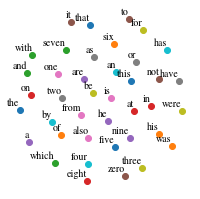

In [17]:
basename = 'figures/embedding-words_regularized'

sparse_plot_words(model, sample_size, basename, matrix)

## Section 5: Experiment

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets.

In [2]:
configurations = [
    # ('random', 'random', 'random', 'random'),
    ('vsm', 'bow', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32),
    ('vsm', 'bow', 'wmd', 1),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1),
    ('vsm', 'bow', 'wmd', 32),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32),
]
configuration_names = {
    ('random', 'random', 'random', 'random'): 'Random',
    ('vsm', 'bow', 'inner_product', 32): 'BoW',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32): 'Soft VSM',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1): 'Soft VSM (quan.)',
    ('vsm', 'bow', 'wmd', 32): 'WMD',
    ('vsm', 'bow', 'wmd', 1): 'WMD (quant.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32): r'Soft VSM (ortho.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1): r'Soft VSM (quan., ortho.)',
}

There are several parameters that are tuned by grid search.

- Soft VSM (sparse):
    - `symmetric`${}\in\{$ `True`, `False` $\}$
    - `dominant`${}\in\{$ `True`, `False` $\}$
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$
    - `nonzero_limit`${}\in\{100, 200, 400, 800\}$
    - `threshold`${}\in\{-1.0, -0.5, 0.0, 0.5\}$
    - `exponent`${}\in\{1, 2, 3, 4\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$
- $k$NN:
    - $k\in\{1,3,\ldots,19\}$.

In [3]:
parameters = [
    'symmetric',
    'dominant',
    'tfidf',
    'nonzero_limit',
    'threshold',
    'exponent',
    'slope',
    'k',
]

   
### Subsection 5.2: Datasets


In [4]:
from math import sqrt

from common import ClassificationResult

dataset_names = []
results = dict()

def load_results(name):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    """

    dataset_names.append(name)
    results[name] = dict()
    datasets = None
    for configuration in configurations:
        basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
        try:
            result = ClassificationResult.from_file(basename)
        except IOError:
            if datasets is None:
                import dataset
                dataset_loader = dataset.__dict__['load_{}'.format(name)]
                datasets = dataset_loader()
            train, validation, test = datasets
            result = train.classify(validation, test, *configuration)
            result.to_file(basename)
        results[name][configuration] = result

For classification, we use the following datasets:


- [BBCSport][BBC] (2005, 255K, 737 documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [5]:
load_results('bbcsport')

2019-10-20 03:11:48,743 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:48,745 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:48,747 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:48,748 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:48,749 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:48,750 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:48,763 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-

- [TWITTER][] (2011, 160K, 6.4k documents subsampled to 3,108 documents, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [6]:
load_results('twitter')

2019-10-20 03:11:48,914 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:48,916 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:48,917 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:48,918 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:48,919 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:48,920 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:48,933 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-32.pkl.


- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [7]:
# load_results('bbc', load_bbc)


- [OHSUMED][] (1994, 24M, 50.22k documents, *free*)
    - We only use documents in a single category.
    - For computational efficiency, we subsample the dataset, using the first 10 classes.

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [8]:
load_results('ohsumed')

2019-10-20 03:11:49,266 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:49,268 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:49,269 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:49,270 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,271 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:49,272 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,285 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-32.pkl.


- [Reuters-21578][] (1987, 8.2M, 215.78k documents, *free*)
    - We use the 8-class version with train / test split as described in [Cardoso-Cachopo (2007)][cardosocapocho07].

 [cardosocapocho07]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.96.7709&rep=rep1&type=pdf (Improving Methods for Single-label Text Categorization)
 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [9]:
load_results('reuters')

2019-10-20 03:11:49,438 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:49,440 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:49,441 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:49,442 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,443 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:49,444 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,457 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-32.pkl.


- [AMAZON][] (2015, 20G, 142.8m documents subsampled to 8,000 documents, *free*)
    - We only use the “Books”, “CDs and Vinyl”, “Electronics”, and “Home and Kitchen” categories.

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [10]:
load_results('amazon')

2019-10-20 03:11:49,622 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:49,624 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:49,625 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:49,626 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,627 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:49,628 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,641 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.



- [20 Newsgroups][] (1995, 14M, 18.83k documents, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [11]:
load_results('20news')

2019-10-20 03:11:49,810 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-inner_product-32.pkl.xz.
2019-10-20 03:11:49,812 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-10-20 03:11:49,813 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-wmd-1.pkl.xz.
2019-10-20 03:11:49,814 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,815 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-wmd-32.pkl.xz.
2019-10-20 03:11:49,816 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-10-20 03:11:49,829 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.


## Section 6: Results
 
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

In [12]:
!make figures

make: 'figures' is up to date.


In [14]:
from itertools import product, repeat
import lzma
import pickle

from gensim.matutils import corpus2csc, unitvec
from gensim.models import TfidfModel
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as preprocessing
from scikits.sparse.cholmod import cholesky

from common import ClassificationResult
import dataset
from dataset import common_dictionary, common_embedding_matrices, pivot_worker, translate_document_worker


def plot_documents(dataset_name, classes, marker_size=6.0):
    global results
    good_result = results[dataset_name]['sparse_soft_vsm', 'tfidf', 'inner_product', 1]
    bad_result = results[dataset_name]['dense_soft_vsm', 'tfidf', 'inner_product', 32]
    params = dict(good_result.params)
    params.update({'symmetric': True, 'dominant': True})
    basename = '{num_bits}-{tfidf}-{symmetric}-{dominant}-{nonzero_limit}-{threshold}-{exponent}'.format(**params)
    
    # Plot documents    
    try:
        with lzma.open('matrices/cholesky-{}.pkl.xz'.format(basename), 'rb') as f:
            sparse_embedding_matrix = pickle.load(f)
    except IOError:
        with lzma.open('matrices/termsim-{}.pkl.xz'.format(basename), 'rb') as f:
            sparse_similarity_matrix = pickle.load(f)
        with lzma.open('matrices/cholesky-{}.pkl.xz'.format(basename), 'wb') as f:
            sparse_embedding_matrix = cholesky(sparse_similarity_matrix).L()
            del sparse_similarity_matrix
            pickle.dump(sparse_embedding_matrix, f, 4)

    dense_embedding_matrix = common_embedding_matrices[32]
    dense_embedding_matrix = preprocessing.normalize(dense_embedding_matrix, norm='l2')
    
    fig = plt.figure(figsize=(19, 6.35))
    dataset_loader = dataset.__dict__['load_{}'.format(dataset_name)]
    train, validation, test = dataset_loader()
    X = train.corpus + validation.corpus + test.corpus
    Y = np.array(train.target + validation.target + test.target, dtype=int)
    tfidf = TfidfModel(dictionary=train.dictionary, smartirs='dtn')
    np.random.seed(42)

    X_dense_soft_vsm = map(train.dictionary.doc2bow, X)
    X_dense_soft_vsm = map(pivot_worker, zip(
        tfidf[X_dense_soft_vsm],
        repeat(1.0),
        repeat(train.avgdl),
    ))
    X_dense_soft_vsm = map(translate_document_worker, zip(
        X_dense_soft_vsm,
        repeat(train.dictionary),
        repeat(common_dictionary),
    ))
    X_dense_soft_vsm = corpus2csc(X_dense_soft_vsm, len(common_dictionary))
    X_dense_soft_vsm = scipy.sparse.csc_matrix.dot(
        dense_embedding_matrix.T,
        X_dense_soft_vsm,
    ).T
    X_dense_soft_vsm = PCA(n_components=50).fit_transform(X_dense_soft_vsm)
    X_dense_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_dense_soft_vsm)

    ax = plt.subplot(1, 3, 1)
    ax.set_title('{} (dense SCM, 32b)'.format(dataset_name))
    ax.scatter(*X_dense_soft_vsm.T, c=Y, s=marker_size**2)

    X_sparse_soft_vsm = map(train.dictionary.doc2bow, X)
    X_sparse_soft_vsm = map(pivot_worker, zip(
        tfidf[X_sparse_soft_vsm],
        repeat(1.0),
        repeat(train.avgdl),
    ))
    X_sparse_soft_vsm = map(translate_document_worker, zip(
        X_sparse_soft_vsm,
        repeat(train.dictionary),
        repeat(common_dictionary),
    ))
    X_sparse_soft_vsm = corpus2csc(X_sparse_soft_vsm, len(common_dictionary))
    X_sparse_soft_vsm_norm = X_sparse_soft_vsm.T.dot(sparse_embedding_matrix).multiply(X_sparse_soft_vsm.T).sum(axis=1).T
    X_sparse_soft_vsm = X_sparse_soft_vsm.multiply(scipy.sparse.csr_matrix(1 / np.sqrt(X_sparse_soft_vsm_norm)))
    X_sparse_soft_vsm = scipy.sparse.csc_matrix.dot(sparse_embedding_matrix.T, X_sparse_soft_vsm).T.todense()
    X_sparse_soft_vsm = PCA(n_components=50).fit_transform(X_sparse_soft_vsm)
    X_sparse_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_sparse_soft_vsm)

    ax = plt.subplot(1, 3, 2)
    ax.set_title('{} (sparse SCM, 1b)'.format(dataset_name))
    ax.scatter(*X_sparse_soft_vsm.T, c=Y, s=marker_size**2)

    plt.tight_layout()
    plt.savefig('figures/classification-datasets-{}.pdf'.format(dataset_name))
    
    # Plot dots    
    fig = plt.figure()
    plt.scatter(
        np.arange(len(classes)),
        np.arange(len(classes)),
        c=np.arange(len(classes)),
    )
    plt.savefig('figures/classification-dots-{}.pdf'.format(dataset_name))
    
    # Plot confusion matrices
    alpha = 1.0
    tick_marks = np.arange(len(classes))

    if len(classes) > 10:
        fig = plt.figure(figsize=(13, 3.6))
    elif len(classes) == 5:
        fig = plt.figure(figsize=(3.25, 0.9))
    else:
        fig = plt.figure(figsize=(6.5, 1.8))

    ax = fig.add_subplot(131)
    ax = fig.add_subplot(131)
    result = bad_result
    confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_matrix = confusion_matrix**alpha
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    ax = fig.add_subplot(132)
    result = good_result
    confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_matrix = confusion_matrix**alpha
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.savefig('figures/classification-confusion_matrices-{}.pdf'.format(dataset_name), dpi=600)

2019-10-20 03:11:50,772 : INFO : 'pattern' package not found; tag filters are not available for English
2019-10-20 03:11:51,218 : INFO : Loading dataset from file corpora/fil8.pkl.xz.
2019-10-20 03:11:55,859 : INFO : loading projection weights from vectors/1b_1000d_vectors_e10_nonbin.xz
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-10-20 03:13:05,720 : INFO : loaded (60238, 1000) matrix from vectors/1b_1000d_vectors_e10_nonbin.xz
2019-10-20 03:13:05,721 : INFO : loading projection weights from vectors/32b_200d_vectors_e10_nonbin.xz
2019-10-20 03:13:22,878 : INFO : loaded (60238, 200) matrix from vectors/32b_200d_vectors_e10_nonb

### Figure 2: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (50.71% test error, left) and regularized (24.14% test error, right) word embeddings on the OHSUMED dataset.

2019-10-20 03:14:11,195 : INFO : Loading dataset from file corpora/ohsumed_train.pkl.xz.
2019-10-20 03:14:11,365 : INFO : Loading dataset from file corpora/ohsumed_validation.pkl.xz.
2019-10-20 03:14:11,423 : INFO : Loading dataset from file corpora/ohsumed_test.pkl.xz.
2019-10-20 03:19:44,549 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-20 03:19:45,058 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to

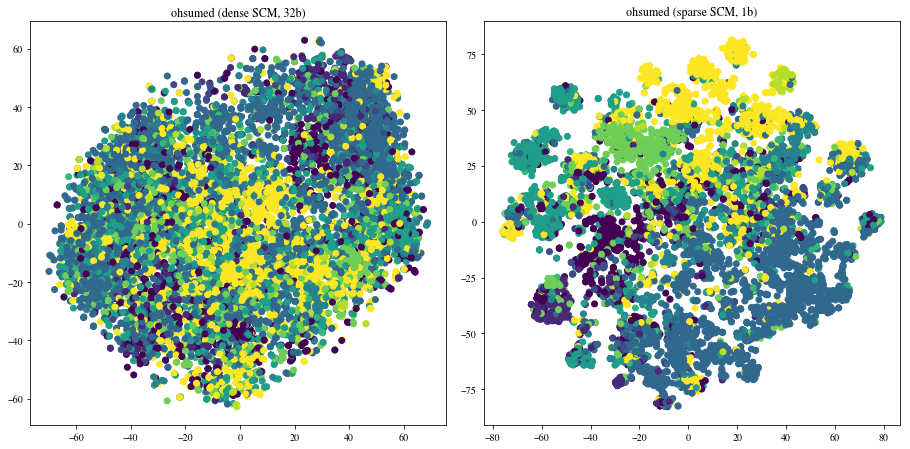

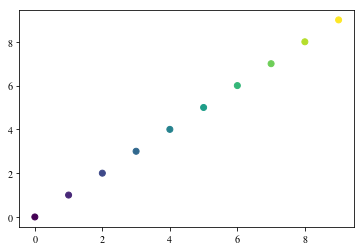

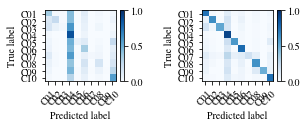

In [15]:
dataset_name = 'ohsumed'
classes = ('C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10')

plot_documents(dataset_name, classes)

### Figure 3: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (21.82% test error, left) and regularized (2.27% test error, right) word embeddings on the BBCSPORT dataset.

2019-10-20 03:26:59,036 : INFO : Loading dataset from file corpora/bbcsport_train.pkl.xz.
2019-10-20 03:26:59,084 : INFO : Loading dataset from file corpora/bbcsport_validation.pkl.xz.
2019-10-20 03:26:59,099 : INFO : Loading dataset from file corpora/bbcsport_test.pkl.xz.
2019-10-20 03:27:53,857 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-20 03:27:54,015 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label

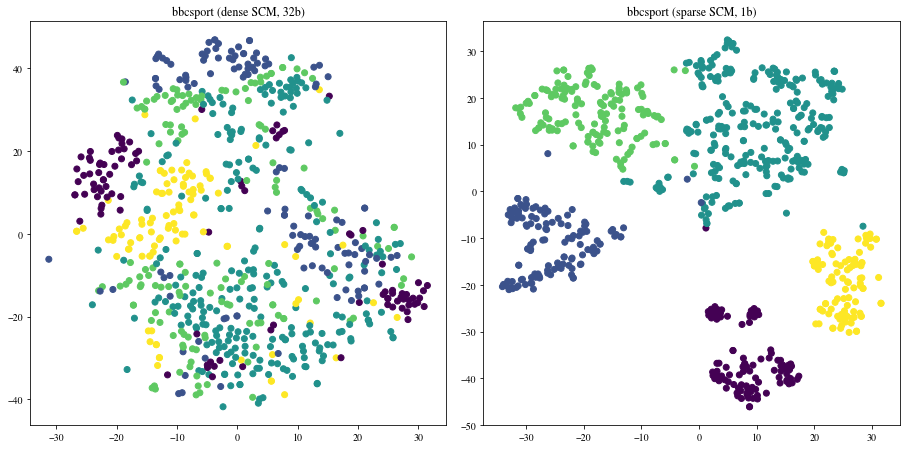

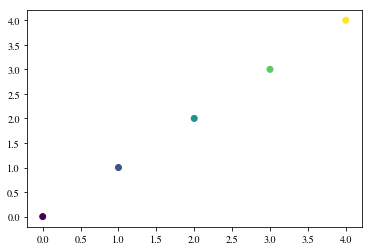

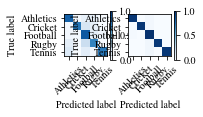

In [16]:
dataset_name = 'bbcsport'
classes = ('Athletics', 'Cricket', 'Football', 'Rugby', 'Tennis')

plot_documents(dataset_name, classes)

### The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (31.22% test error, left) and regularized (31.01% test error, right) word embeddings on the TWITTER dataset.

2019-10-20 03:30:02,944 : INFO : Loading dataset from file corpora/twitter_train.pkl.xz.
2019-10-20 03:30:02,958 : INFO : Loading dataset from file corpora/twitter_validation.pkl.xz.
2019-10-20 03:30:02,963 : INFO : Loading dataset from file corpora/twitter_test.pkl.xz.
2019-10-20 03:31:16,051 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-20 03:31:16,299 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to

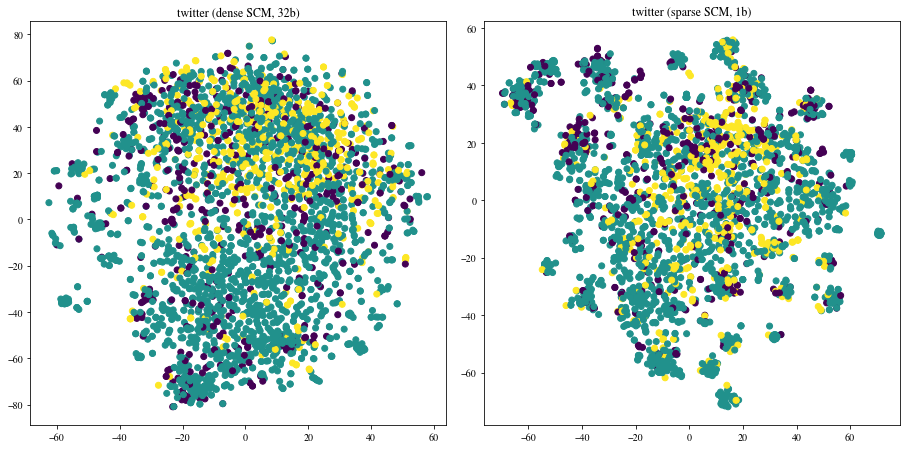

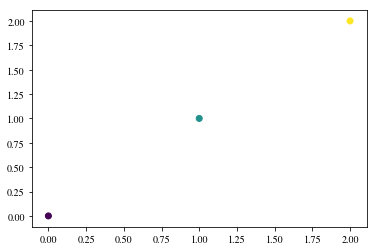

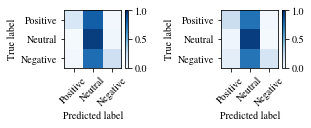

In [17]:
dataset_name = 'twitter'
classes = ('Positive', 'Neutral', 'Negative')

plot_documents(dataset_name, classes)

### Figure 4: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (10.19% test error, left) and regularized (7.22% test error, right) word embeddings on the REUTERS dataset.

2019-10-20 03:36:32,379 : INFO : Loading dataset from file corpora/reuters_train.pkl.xz.
2019-10-20 03:36:32,561 : INFO : Loading dataset from file corpora/reuters_validation.pkl.xz.
2019-10-20 03:36:32,627 : INFO : Loading dataset from file corpora/reuters_test.pkl.xz.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
2019-10-20 03:43:22,151 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-20 03:43:22,665 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a

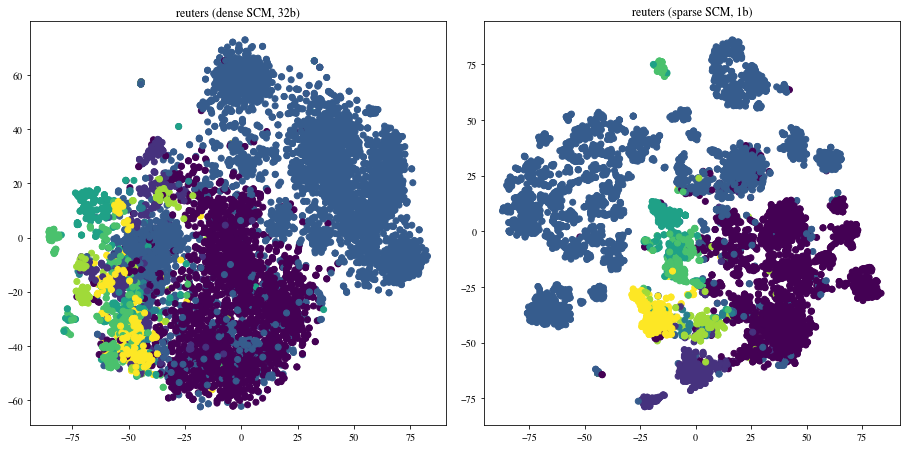

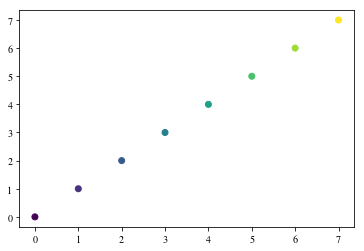

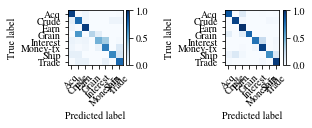

In [18]:
dataset_name = 'reuters'
classes = ('Acq', 'Crude', 'Earn', 'Grain', 'Interest',  'Money-fx', 'Ship', 'Trade')

plot_documents(dataset_name, classes)

### Figure 5: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (10.04% test error, left) and regularized (6.33% test error, right) word embeddings on the AMAZON dataset.

2019-10-20 03:44:11,670 : INFO : Loading dataset from file corpora/amazon_train.pkl.xz.
2019-10-20 03:44:11,933 : INFO : Loading dataset from file corpora/amazon_validation.pkl.xz.
2019-10-20 03:44:12,012 : INFO : Loading dataset from file corpora/amazon_test.pkl.xz.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
2019-10-20 03:49:21,081 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-20 03:49:21,554 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

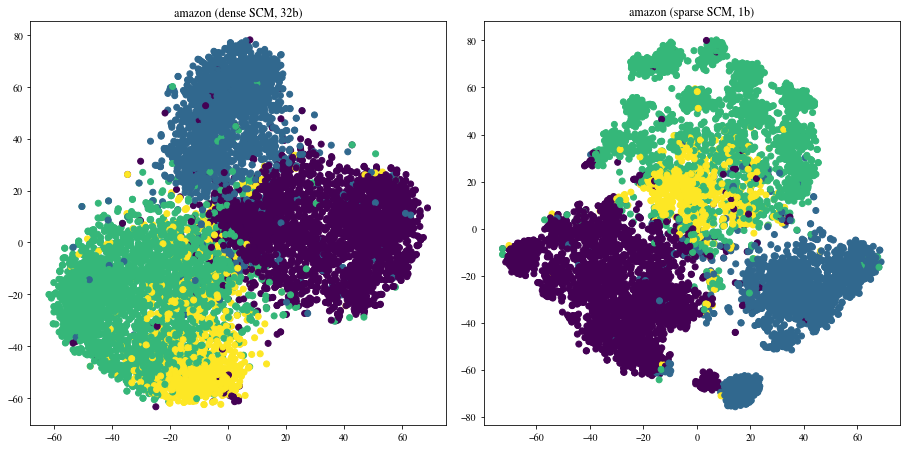

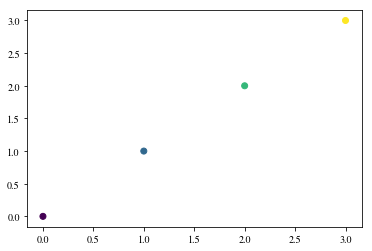

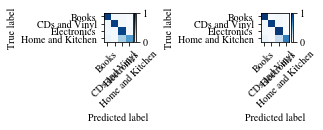

In [19]:
dataset_name = 'amazon'
classes = ('Books', 'CDs and Vinyl', 'Electronics', 'Home and Kitchen')

plot_documents(dataset_name, classes)

### Figures 6 and 7: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (42.53% test error, left) and regularized (29.97% test error, right) word embeddings on the 20NEWS dataset.

2019-10-25 16:20:21,025 : INFO : Loading dataset from file corpora/newsgroups_train.pkl.xz.
2019-10-25 16:20:22,596 : INFO : Loading dataset from file corpora/newsgroups_validation.pkl.xz.
2019-10-25 16:20:22,816 : INFO : Loading dataset from file corpora/newsgroups_test.pkl.xz.
2019-10-25 16:43:12,230 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
2019-10-25 16:43:13,025 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique

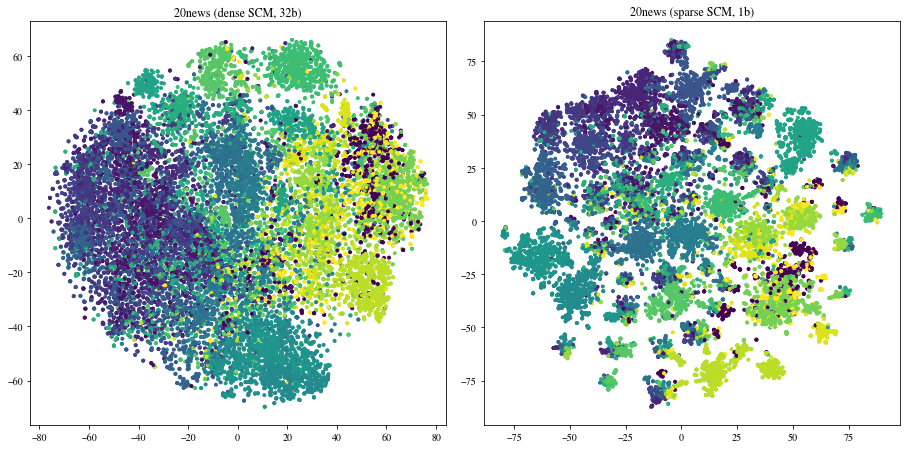

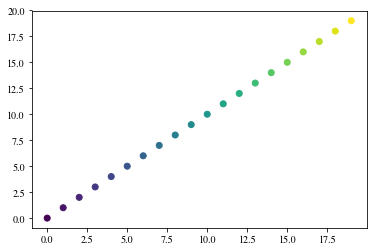

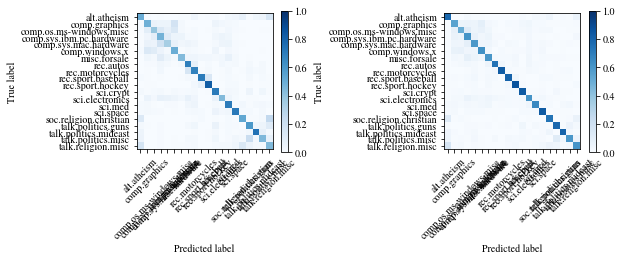

In [16]:
dataset_name = '20news'
classes = (
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc',
)

plot_documents(dataset_name, classes, marker_size=3.0)

### Figure 8: 95% interval estimates for the $k$NN test error on six text classification datasets.

2019-10-15 00:40:47,496 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


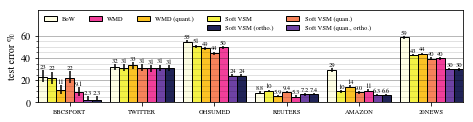

In [21]:
from itertools import chain, cycle

import numpy as np
from matplotlib.patches import Rectangle


def flip(items, ncol):
    return chain(*[items[i::ncol] for i in range(ncol)])

num_bars = len(configurations)
num_datasets = len(dataset_names)
bar_width = 1.0 / (num_bars + 2)
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))
bar_xs = [
    np.arange(num_datasets) * bar_width * (num_bars + 1) + bar_width * (bar_number - 0.5 * num_bars)
    for bar_number in range(num_bars)
]

fig = plt.figure(figsize=(6.68, 1.8))
# fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, color in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(palette),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color=color, yerr=yerr, capsize=0, label=label)
    for x, y, yerr_upper in zip(x, y, yerr_upper):
        plt.text(
            x=x - (0.44 if y < 10 else 0.35) * bar_width,
            y=y + yerr_upper + 1.5,
            s='{:.1f}'.format(y) if y < 10 else '{:.0f}'.format(y),
            size=6.5,
        )
    # plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
handles.insert(-2, Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False))
handles.insert(-2, Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False))
handles.insert(-2, Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False))
labels.insert(-2, ' ')
labels.insert(-2, ' ')
labels.insert(-2, ' ')
handles[1], handles[4] = handles[4], handles[1]
labels[1], labels[4] = labels[4], labels[1]
handles[3], handles[4] = handles[4], handles[3]
labels[3], labels[4] = labels[4], labels[3]
handles[8], handles[9] = handles[9], handles[8]
labels[8], labels[9] = labels[9], labels[8]
ncol = 5
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='upper left', ncol=ncol, prop={'size': 6.5})

plt.xticks(bar_xs[num_bars // 2], map(lambda x: x.upper(), dataset_names), size=6.5)
ax.set_yticks([0, 20, 40, 60], minor=False)
ax.set_yticks([5, 10, 15, 25, 30, 35, 45, 50, 55], minor=True)
plt.ylabel('test error %')
plt.xlim((-0.5 * (num_bars + 1) * bar_width, (num_datasets - 1) * bar_width * (num_bars + 1) + 0.5 * (num_bars - 1) * bar_width))
plt.ylim(0, 83)
plt.grid(axis='y', which='major', color='k', alpha=0.35)
plt.grid(axis='y', which='minor', color='k', alpha=0.15)
plt.tight_layout()
plt.savefig('figures/classification-test_error.pdf')
plt.show()

### Figure 9: Average $k$NN test error compared to BOW.

2019-10-15 00:41:01,457 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


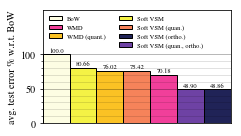

In [22]:
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))

bar_ys = list(map(lambda x: sum(x) / len(x), bar_ys))
bar_yerrs_lower = list(map(lambda x: sum(x) / len(x), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: sum(x) / len(x), bar_yerrs_upper))

baseline_configuration = ('vsm', 'bow', 'inner_product', 32)
baseline_configuration_index = configurations.index(baseline_configuration)
baseline_y = bar_ys[baseline_configuration_index]

bar_ys = list(map(lambda x: (x / baseline_y, ), bar_ys))
bar_yerrs_lower = list(map(lambda x: (x / baseline_y, ), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: (x / baseline_y, ), bar_yerrs_upper))
# bar_yerrs_lower[baseline_configuration_index] = (0.0, )
# bar_yerrs_upper[baseline_configuration_index] = (0.0, )
bar_xs = [
    bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]

fig = plt.figure(figsize=(3.45, 2))
# fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, color in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(palette),
        ):
    plt.bar(x, y, width=bar_width, edgecolor='black', color=color, capsize=0, label=label)
    # plt.bar(x, y, width=bar_width, edgecolor='black', capsize=0, label=label)
    plt.text(
        x=x - (0.26 if y[0] < 1 else 0.26) * bar_width,
        y=y[0] + 0.04,
        s=('{:.2f}' if y[0] < 1 else '{:.1f}').format(y[0] * 100),
        size=6.5,
    )

handles, labels = ax.get_legend_handles_labels()
handles.insert(-1, Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False))
labels.insert(-1, ' ')
handles[2], handles[4] = handles[4], handles[2]
labels[2], labels[4] = labels[4], labels[2]
handles[5], handles[7] = handles[7], handles[5]
labels[5], labels[7] = labels[7], labels[5]
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='upper left', ncol=ncol, prop={'size': 6.5})

# plt.xticks(
#     np.add(-0.5 * num_bars * bar_width + 0.5 * bar_width, np.arange(num_bars) * bar_width),
#     map(lambda x: configuration_names[x], configurations)
# )
plt.xticks((), ())
plt.yticks((0.0, 0.5, 1.0), (0, 50, 100))
ax.set_yticks([0, 0.5, 1.0], minor=False)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9], minor=True)
plt.ylabel('avg. test error % w.r.t. BoW')
plt.xlim((-0.5 * num_bars * bar_width, 0.5 * num_bars * bar_width))
plt.ylim((0.0, 1.65))
plt.grid(axis='y', which='major', color='k', alpha=0.35)
plt.grid(axis='y', which='minor', color='k', alpha=0.15)
plt.tight_layout()
plt.savefig('figures/classification-avg_test_error_ratio.pdf')
plt.show()

### Figure 10: Average document processing speed on one Intel Xeon X7560 2.26 GHz core.

2019-10-15 00:41:25,995 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


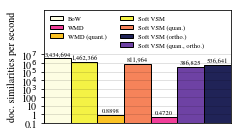

In [23]:
import numpy as np

from common import read_speeds

wmd_num_workers = 64
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0],
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0] - read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[1],
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            
            )[2] - read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0],
        ),
    )
    for configuration in configurations
))))

fig = plt.figure(figsize=(3.45, 2))
# fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, color in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(palette),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color=color, capsize=0, label=label)
    plt.text(
        x=x - (0.33 if y[0] < 1 else (0.39 if y[0] < 10**6 else 0.46)) * bar_width,
        y=y[0] * 2,
        s=('{:.4f}' if y[0] < 1 else '{:,.0f}').format(y[0]),
        size=6.5,
    )

handles, labels = ax.get_legend_handles_labels()
handles.insert(-1, Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False))
labels.insert(-1, ' ')
handles[2], handles[4] = handles[4], handles[2]
labels[2], labels[4] = labels[4], labels[2]
handles[5], handles[7] = handles[7], handles[5]
labels[5], labels[7] = labels[7], labels[5]
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='upper left', ncol=ncol, prop={'size': 6.5})

plt.xticks((), ())
plt.yscale('log')
plt.yticks(
    (10.0**np.arange(-1, 12)),
    ('0.1', '1', '10', '100', '10$^3$', '10$^4$', '10$^5$', '10$^6$', '10$^7$'),
)
ax.set_yticks(10.0**np.arange(-1, 8), minor=False)
plt.ylabel('doc. similarities per second')
plt.xlim((-0.5 * num_bars * bar_width, 0.5 * num_bars * bar_width))
plt.grid(axis='y', which='major', color='k', alpha=0.15)
# plt.grid(axis='y', which='minor', color='k', alpha=0.15)
plt.tight_layout()
plt.ylim((0.1, 10**12.2))
plt.savefig('figures/classification-avg_speed.pdf')
plt.show()

### Paragraph: Significance Testing

In [24]:
from itertools import product, combinations

from common import f_test

kwargs = list(product(dataset_names, combinations(configurations, 2)))
result_pairs = map(lambda x: (results[x[0]][x[1][0]], results[x[0]][x[1][1]]), kwargs)
test_results = f_test(result_pairs)

for (dataset, (first_configuration, second_configuration)), test_result in zip(kwargs, test_results):
    if not test_result:
        first_configuration_name = configuration_names[first_configuration]
        second_configuration_name = configuration_names[second_configuration]
        print("Not different mean: {}, {}, {}".format(
            dataset,
            first_configuration_name,
            second_configuration_name,
    ))

Not different mean: bbcsport, Soft VSM, Soft VSM (quan.)
Not different mean: bbcsport, Soft VSM (quan., ortho.), Soft VSM (ortho.)
Not different mean: twitter, Soft VSM, Soft VSM (quan.)
Not different mean: twitter, Soft VSM (quan.), Soft VSM (quan., ortho.)
Not different mean: ohsumed, Soft VSM (quan., ortho.), Soft VSM (ortho.)


### Paragraph: Sentiment analysis

In [25]:
from dataset import common_embeddings

from IPython.display import display, Markdown

for num_bits, embeddings in common_embeddings.items():
    display(Markdown('#### {} bits'.format(num_bits)))
    for w1, w2 in [
                ('good', 'bad'),
                ('happy', 'sad'),
                ('love', 'hate'),
            ]:
        similarity = embeddings.similarity(w1, w2)
        i1 = [word for word, _ in embeddings.most_similar(w1, topn=10000)].index(w2) + 1
        i2 = [word for word, _ in embeddings.most_similar(w2, topn=10000)].index(w1) + 1
        display(Markdown(
            '{w1} and {w2}:\n'
            '- cosine similarity: {similarity}\n'
            "- {w2} is {w1}'s nearest neighbor number {i1}\n"
            "- {w1} is {w2}'s nearest neighbor number {i2}\n".format(
                w1=w1,
                w2=w2,
                similarity=similarity,
                i1=i1,
                i2=i2,
            )
        ))

2019-08-31 23:51:44,011 : INFO : 'pattern' package not found; tag filters are not available for English
2019-08-31 23:51:44,229 : INFO : Loading dataset from file corpora/fil8.pkl.xz.
2019-08-31 23:51:48,689 : INFO : loading projection weights from vectors/1b_1000d_vectors_e10_nonbin.xz
/mnt/storage/home/novotny/.virtualenvs/regularized-embeddings/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-08-31 23:52:59,030 : INFO : loaded (60238, 1000) matrix from vectors/1b_1000d_vectors_e10_nonbin.xz
2019-08-31 23:52:59,031 : INFO : loading projection weights from vectors/32b_200d_vectors_e10_nonbin.xz
2019-08-31 23:53:16,315 : INFO : loaded (60238, 200) matrix from vectors/32b_200d_vectors_e10_nonb

#### 32 bits

2019-08-31 23:53:18,260 : INFO : precomputing L2-norms of word weight vectors


good and bad:
- cosine similarity: 0.5848290920257568
- bad is good's nearest neighbor number 1
- good is bad's nearest neighbor number 1


happy and sad:
- cosine similarity: 0.3102347254753113
- sad is happy's nearest neighbor number 150
- happy is sad's nearest neighbor number 302


love and hate:
- cosine similarity: 0.29332810640335083
- hate is love's nearest neighbor number 899
- love is hate's nearest neighbor number 313


#### 1 bits

2019-08-31 23:53:18,476 : INFO : precomputing L2-norms of word weight vectors


good and bad:
- cosine similarity: 0.4020000398159027
- bad is good's nearest neighbor number 1
- good is bad's nearest neighbor number 1


happy and sad:
- cosine similarity: 0.0860000029206276
- sad is happy's nearest neighbor number 2226
- happy is sad's nearest neighbor number 2090


love and hate:
- cosine similarity: 0.16600000858306885
- hate is love's nearest neighbor number 133
- love is hate's nearest neighbor number 41


### Figure 11: Cosine similarity between word embeddings.

In [26]:
import pandas as pd
from sklearn.preprocessing import normalize

similarities = {}
for num_bits, embeddings in common_embeddings.items():
    embeddings = normalize(embeddings.vectors, norm='l2')
    num_words = embeddings.shape[0]
    similarities[num_bits] = pd.Series(
        [
            embeddings[i].T.dot(embeddings[j])
            for i, j in combinations(range(num_words), 2)
        ],
        name='Cosine similarity between a pair of different words ({} bits)'.format(num_bits),
    )

In [27]:
for num_bits, similarity in similarities.items():
    display(similarity.describe())

count    1.814278e+09
mean     1.531527e-01
std      8.098538e-02
min     -4.761427e-01
25%      9.843644e-02
50%      1.545602e-01
75%      2.093369e-01
max      9.408390e-01
Name: Cosine similarity between a pair of different words (32 bits), dtype: float64

count    1.814278e+09
mean     2.828812e-02
std      3.668024e-02
min     -2.740004e-01
25%      4.000006e-03
50%      2.800005e-02
75%      5.200009e-02
max      6.560012e-01
Name: Cosine similarity between a pair of different words (1 bits), dtype: float64

2019-08-29 19:23:49,545 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


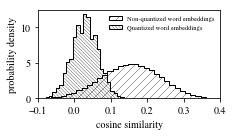

In [28]:
import numpy as np

def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn) * 2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn) * 2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2 * bb + 1] = binsIn[bb]
        bins[2 * bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2 * bb + 1] = histIn[bb]
            data[2 * bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

fig = plt.figure(figsize=(3.45, 2))
ax = fig.add_subplot(111)
for num_bits, similarity in similarities.items():
    bins, n = histOutline(similarity.values, bins=100, density=True)
    plt.fill_between(
        bins,
        n,
        facecolor='none',
        edgecolor='black',
        hatch=('\\\\\\\\\\\\\\' if num_bits == 1 else '///'),
        label=('Quantized word embeddings' if num_bits == 1 else 'Non-quantized word embeddings'),
    )
plt.legend(loc='best', prop={'size': 6.5})
plt.xlabel('cosine similarity')
plt.ylabel('probability density')
plt.xlim(-0.1, 0.4)
plt.ylim(0, None)
plt.tight_layout()
plt.savefig('figures/embedding-similarities.pdf')
plt.show()

### Table 2: Optimal parameter values for the soft VSM with orthogonalized word embeddings.

In [29]:
dataset_params = {}
for name in dataset_names:
    result = results[name]['sparse_soft_vsm', 'tfidf', 'inner_product', 32]
    dataset_params[name] = {}
    for parameter, value in result.params.items():
        if parameter in parameters:
            dataset_params[name][parameter] = value
dataset_params

{'20news': {'dominant': False,
  'exponent': 3,
  'k': 1,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': False,
  'tfidf': True,
  'threshold': -1.0},
 'amazon': {'dominant': True,
  'exponent': 4,
  'k': 17,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'bbcsport': {'dominant': True,
  'exponent': 2,
  'k': 1,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'ohsumed': {'dominant': True,
  'exponent': 4,
  'k': 11,
  'nonzero_limit': 200,
  'slope': 0.0,
  'symmetric': False,
  'tfidf': True,
  'threshold': -1.0},
 'reuters': {'dominant': True,
  'exponent': 4,
  'k': 19,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'twitter': {'dominant': False,
  'exponent': 2,
  'k': 13,
  'nonzero_limit': 400,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0}}

### Optimal parameter values for all document similarities.

In [30]:
parameter_frequencies = {}
for name in dataset_names:
    for result in results[name].values():
        for parameter, value in result.params.items():
            if parameter not in parameters:
                continue
            if parameter not in parameter_frequencies:
                parameter_frequencies[parameter] = {}
            if value not in parameter_frequencies[parameter]:
                parameter_frequencies[parameter][value] = 0
            parameter_frequencies[parameter][value] += 1
parameter_frequencies

{'dominant': {False: 5, True: 7},
 'exponent': {1: 2, 2: 6, 3: 1, 4: 3},
 'k': {1: 9, 3: 2, 5: 2, 7: 2, 9: 3, 11: 8, 13: 2, 15: 1, 17: 3, 19: 4},
 'nonzero_limit': {100: 7, 200: 2, 400: 2, 800: 1},
 'slope': {0.0: 24},
 'symmetric': {False: 4, True: 8},
 'tfidf': {False: 3, True: 9},
 'threshold': {-1.0: 12}}